## Scientific Machine Learning 2026, Tutorial 1 part 1:
#Learning the Ising Hamiltonian using linear regression

Perimeter Scholars International 2025-2026

This is a notebook modified from Lauren Hayward's notebook by Gang Xu

**References:** Section VI.D of https://arxiv.org/abs/1803.08823, and the corresponding Notebook D from https://physics.bu.edu/~pankajm/MLnotebooks.html

### Generate the data set:<span style="color:blue"> (Play with M and N here)

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import linear_model
%matplotlib inline

np.random.seed(2026) # we usually set a random seed so whatever we do is repeatable

M = 10000  #number of samples
N = 100   #number of spins
J = 1.0  #coupling energy for generating the data

#Randomly generate the spin configurations
s = np.random.choice([-1,1], size=(M,N))

def getEnergy_nnIsing1D(s):
  return -J*np.sum(s*np.roll(s,-1,axis=1),axis=1) 
    # np.roll shifts the big M by N matrix left by one (-1) and it is applied rowwise(across columns) (axis=1)
#s*np.roll elementwise multiplication 
#np.sum (...axis=1) sum along columns for each row
H = getEnergy_nnIsing1D(s) #Labels for each configuration



### Introduce the variables X <span style="color:blue"> Fill in the paranthesis of x=np.einsum() part (c)

In [47]:
# Introduce the variable x as in part b): s_j*s_k --> x_p 
#effectively x[..., j,k]=s[...,j]*s[...,k]
#np.einsum('ij,j->i', A,x) will do the matrix multiplication \sum_jA_{ij}x_{j} sum over repeated index and -> make sure i stay unsummed
#if you have a repeated index, but does not want it to be summed over use ... to represent it everywhere
#write part c) code here using np.einsum, fill in the paranthesis

x=np.einsum('...j,...k->...jk', s, s)


#Consider only the upper triangular part of this matrix since we only want to consider k>j:
iu = np.triu_indices(x.shape[1],k=1) #k=1 means strictly above the main diagonal x has dimension (M,N,N) so x.shape[1]=N
#triu_indices produces row and column indices for the upper triangle so a 3*3 matrix will return
#[0,0,1][1,2,2] representing the pairs 0,1 0,2 1,2
print(x.shape)
x = x[:,iu[0],iu[1]]#now for each row(M) : take all the elements indexed as upper triangle above
print(x.shape) # notice that this process will change the shape of our features from a 3d array to a 2d one which is what we need 

(10000, 100, 100)
(10000, 4950)


### Define a function to plot the coupling parameters $J_{jk}$ <span style="color:blue">(No need to change anything here)

In [48]:
def plot_J(w,N):
  J = np.zeros((N,N))

  #Fill in the upper triangular part with entries from w:
  iu = np.triu_indices(N,k=1)# same indices as before
  J[iu] = -1.0*w
  print(np.diag(J,k=1))#k=1 means excluding the diagonal, starts from the first super diagonal

  #Plot this matrix:
  max_Jmag = max(np.max(J),-1*np.min(J)) # find the max magnitude of J
  cmap_args=dict(vmin=min(-1.,-1*max_Jmag), vmax=max(1.,max_Jmag), cmap='PRGn')
    #used in imshow below as color mapping parameters vmin is the minimum data value for the colormap, vmax is the maximum data value for the colormap
    #ensures the colormap at least cover [-1,1]. notice it centers around 0. PRGn is from purple to green a diverging colormap

  fig, ax = plt.subplots()#create figure and axes
  im      = ax.imshow(J,**cmap_args)#imshow display a 2D array as an image, each element becomes a pixel values mapped to colors
  # it returns an AxesImage object 
  ax.set_title(r'$J_{jk}$',fontsize=18)

  divider = make_axes_locatable(ax)#make divider
  cax = divider.append_axes("right", size="5%", pad=0.1)#create a new axes on the right
  cbar=fig.colorbar(im, cax=cax)#attach colorbar to this axes

  plt.show()

### Find the parameters $J_{jk}$ using the exact solution <span style="color:blue">(both methods are given, just comment out the one not using) part(d)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]


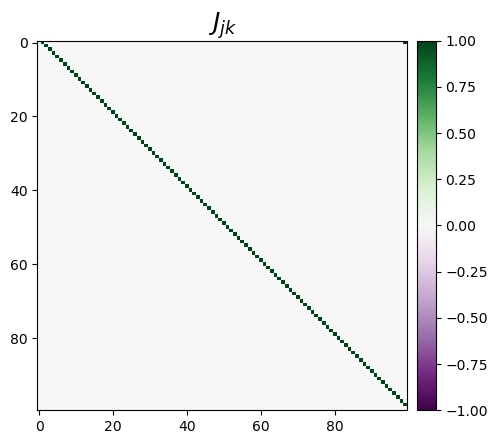

CPU times: total: 2min 1s
Wall time: 32.5 s


In [49]:
%%time

# w_exact = np.linalg.inv(x.T.dot(x)).dot(x.T).dot(H) #the exact solution
w_exact = linear_model.LinearRegression().fit(x, H).coef_ # the exact solution using linear model from sklearn
#print(w_exact)
plot_J(w_exact,N)

### Find the parameters $J_{jk}$ using gradient descent <span style="color:blue"> (need to code to initialize parameter part e) and remove arguments from the Regressor part g))

[1.00050123 0.99891868 0.99991155 0.99970075 1.00181015 1.00075445
 0.99958342 0.99593025 0.99926354 0.99898497 0.9971408  1.00182675
 0.99919975 0.99860943 1.00015032 1.00006567 0.99987609 1.00069797
 0.99951531 1.00001908 1.00040385 1.00014935 0.99990766 0.99998202
 0.99936611 1.00057702 0.99958474 1.00077398 0.99974468 0.99791457
 0.99787555 1.00147337 1.00105859 0.99845199 0.9999701  1.0012692
 0.99894609 1.00148885 0.9992513  0.99950628 0.99990783 0.99949563
 0.99965973 1.00140224 0.99770701 0.9990133  0.99978456 0.99644602
 0.99892146 1.00003382 1.00002474 0.99972451 1.00121703 1.00169032
 0.99818709 0.9975937  0.99749489 1.00018256 1.00029671 0.99941308
 1.00019627 0.99814222 0.99971708 0.99840517 0.99783891 0.99767534
 0.99921896 1.00160505 0.99948178 0.99906152 1.00040654 1.00044069
 1.00175685 0.99880244 0.99997756 0.99868934 0.99760677 0.99957624
 1.00050549 1.00052859 1.00099256 0.99968179 1.00002455 0.99988107
 0.99757231 1.00109461 0.99880241 0.99929961 0.99884222 1.00007

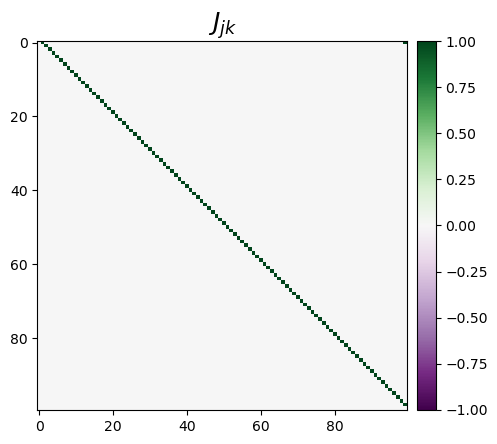

CPU times: total: 6.2 s
Wall time: 5.89 s


In [ ]:
%%time
# student write code here initialize the w parameters randomly 
#the shape of w_init should be changing when you change M or N

d = N * (N - 1) // 2

w_init = np.random.rand(d)

#Apply gradient descent with a constant learning rate of eta0:
w_GD = linear_model.SGDRegressor(penalty=None, learning_rate='constant', eta0=0.0001).fit(x, H, coef_init=w_init).coef_
#student write code here


plot_J(w_GD,N)

[0.99990527 0.99993387 0.99984775 0.99988658 0.9999992  0.99979207
 0.99981576 0.99998914 0.99987612 0.99987219 0.9998099  0.99995015
 0.99982164 0.9999243  0.99990343 0.99988063 0.99994177 0.99992336
 0.99996366 0.99977161 0.99988908 0.9998067  0.99982021 0.99992758
 0.99990173 0.99988478 0.99978227 0.99981776 0.99981543 1.00002949
 0.99981918 0.99977479 0.99974757 0.99989405 0.99990395 0.99979753
 0.99989197 0.99987421 0.99981872 0.99982965 0.99998892 0.99983098
 0.9997707  0.99985001 0.99993883 0.99994564 0.99982047 0.99989112
 0.99977164 0.9998884  1.00000769 0.99987179 0.99983132 0.99977968
 0.99984397 1.0000115  0.99980938 0.99985569 0.99995134 0.99995237
 0.99991553 0.99978113 0.99982022 0.99984982 0.99980581 0.99984901
 0.99985037 0.99986286 0.9999587  0.99977082 0.99988323 0.99992417
 0.99994214 0.99985747 0.9999607  0.99989168 0.99982789 0.99991607
 0.99988607 0.99980728 0.99998372 0.9998878  0.99989788 0.99992334
 0.999861   0.99999264 0.99979829 0.99991587 0.99988878 1.0000

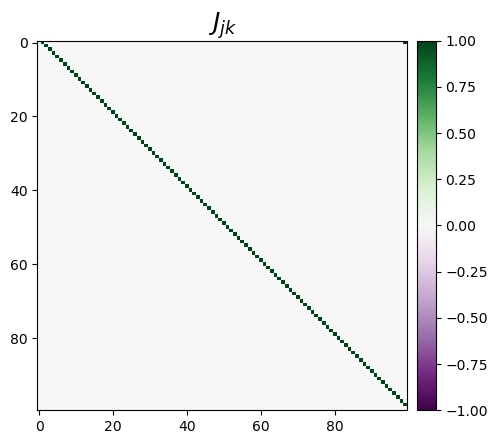

CPU times: total: 17.9 s
Wall time: 17.6 s


In [52]:
%%time
# student write code here initialize the w parameters randomly 
#the shape of w_init should be changing when you change M or N

d = N * (N - 1) // 2

w_init = np.random.rand(d)

#Apply gradient descent:
w_GD_auto = linear_model.SGDRegressor().fit(x, H, coef_init=w_init).coef_
#student write code here


plot_J(w_GD_auto,N)